In [1]:
import torch
from torch import nn
from torch.nn import init
import numpy as np
import sys
import torchvision
import torchvision.transforms as transforms
import time
import matplotlib.pyplot as plt

什么是LeNet网络

LeNet，它是最早发布的卷积神经网络之一，因其在计算机视觉任务中的高效性能而受到广泛关注。 这个模型是由AT&T贝尔实验室的研究员Yann LeCun在1989年提出的（并以其命名），目的是识别图像 [LeCun et al., 1998]中的手写数字。 当时，Yann LeCun发表了第一篇通过反向传播成功训练卷积神经网络的研究，这项工作代表了十多年来神经网络研究开发的成果。论文文章地址，有兴趣可以深入阅读了解。
下面我们来看下LeNet（LeNet-5）的结构：LeNet网络结构十分简单，它由两个部分组成：一个是卷积编码器，另一个是全连接层密集块。


In [2]:
# 导入FashionMNIST数据集
mnist_train = torchvision.datasets.FashionMNIST(root='~/Datasets/FashionMNIST', train=True, download=True, transform=transforms.ToTensor())
mnist_test = torchvision.datasets.FashionMNIST(root='~/Datasets/FashionMNIST', train=False, download=True, transform=transforms.ToTensor())

100%|██████████| 26421880/26421880 [00:01<00:00, 18471094.81it/s]


Extracting /root/Datasets/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/Datasets/FashionMNIST/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 299609.09it/s]


Extracting /root/Datasets/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/Datasets/FashionMNIST/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5492496.86it/s]


Extracting /root/Datasets/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/Datasets/FashionMNIST/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 12693872.42it/s]

Extracting /root/Datasets/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/Datasets/FashionMNIST/FashionMNIST/raw



In [3]:
# 处理数据集，把数据转换成张量，使数据可以输入下面我们搭建的网络
def load_data_fashion_mnist(mnist_train, mnist_test, batch_size):
    if sys.platform.startswith('win'):
        num_workers = 0
    else:
        num_workers = 4
    train_data = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_data = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    return train_data, test_data


class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5), # in_channels, out_channels, kernel_size
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2), # kernel_size, stride
            nn.Conv2d(6, 16, 5),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2)
        )
        self.fc = nn.Sequential(
            nn.Linear(16*4*4, 120),
            nn.LeakyReLU(0.1),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10)
        )

    def forward(self, img):
        feature = self.conv(img)
        output = self.fc(feature.view(img.shape[0], -1))
        return output


# 测试准确率计算
def evaluate_accuracy(data_iter, net, device=None):
    if device is None and isinstance(net, torch.nn.Module):
        # 如果没指定device就使用net的device
        device = list(net.parameters())[0].device
    acc_sum, n = 0.0, 0
    with torch.no_grad():
        for X, y in data_iter:
            net.eval()  # 评估模式, 这会关闭dropout
            acc_sum += (net(X.to(device)).argmax(dim=1) == y.to(device)).float().sum().cpu().item()
            net.train()  # 改回训练模式
            n += y.shape[0]
    return acc_sum / n


# 训练函数
def train(net, train_data, test_data, batch_size, optimizer, device, num_epochs):
    net = net.to(device)
    print("training on ", device)
    loss_function = torch.nn.CrossEntropyLoss()   # 定义损失函数（交叉熵损失函数）
    ax = []  # 保存等会更新的epoch，loss,train_acc,test_acc，用于绘制动态折线图
    ay1 = []
    ay2 = []
    ay3 = []
    plt.ion()
    # 开始训练
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, batch_count, start = 0.0, 0.0, 0, 0, time.time()  # 初始化参数
        for X, y in train_data:
#             optimizer.zero_grad()##???
            X = X.to(device)      # 把参数导入GPU训练
            y = y.to(device)
            y_hat = net(X)
            l = loss_function(y_hat, y)   # 使用损失函数计算loss
            optimizer.zero_grad()
            l.backward()   # 反向传播
            optimizer.step()
            train_l_sum += l.cpu().item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().cpu().item()
            n += y.shape[0]
            batch_count += 1
        test_acc = evaluate_accuracy(test_data, net)  # 测试当个epoch的训练的网络
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec'
              % (epoch + 1, train_l_sum / batch_count, train_acc_sum / n, test_acc, time.time() - start))
        # 绘制动态折线图（如果不想绘制，可以删掉）
        plt.clf()  # 清除刷新前的图表，防止数据量过大消耗内存
        ax.append(epoch + 1)  # 追加x坐标值
        ay1.append(train_l_sum / batch_count)  # 追加y坐标值
        ay2.append(train_acc_sum / n)
        ay3.append(test_acc)
        plt.plot(ax, ay1, 'g-')
        plt.plot(ax, ay2, 'r-')
        plt.plot(ax, ay3, '-')
        plt.ylabel("epoch")
        plt.plot(ax, ay1, label="loss")  # 在绘图函数添加一个属性label
        plt.plot(ax, ay2, label="train_acc")
        plt.plot(ax, ay3, label="test_acc")
        plt.legend(loc=2)  # 添加图例，loc为图例位置，1为右上角，2为左上角，3为左下角，4为右下角
        plt.grid()   # 添加网格
        plt.pause(5)  # 设置暂停时间，太快图表无法正常显示
        plt.ioff()  # 关闭画图的窗口，即关闭交互模式
    plt.show()  # 显示图片，防止闪退

In [4]:
batch_size = 256   # 批量数大小
train_data, test_data = load_data_fashion_mnist(mnist_train, mnist_test, batch_size)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # 使用GPU,如果没有则使用CPU
net = LeNet()    # 导入我们搭建好的网络
lr, num_epochs = 0.001, 10
optimizer = torch.optim.Adam(net.parameters(), lr=lr)  # 优化函数

training on  cpu
epoch 1, loss 0.9533, train acc 0.647, test acc 0.740, time 7.1 sec


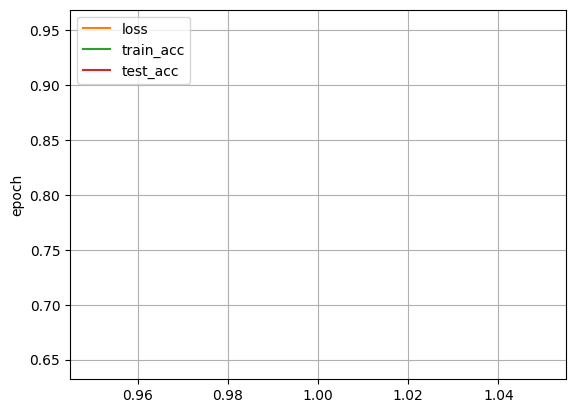

epoch 2, loss 0.5883, train acc 0.774, test acc 0.784, time 6.8 sec


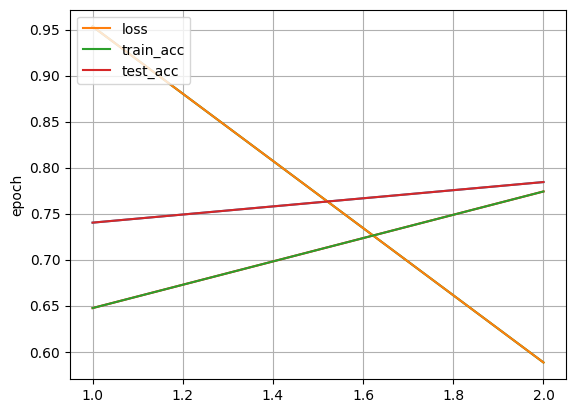

epoch 3, loss 0.4990, train acc 0.815, test acc 0.816, time 7.3 sec


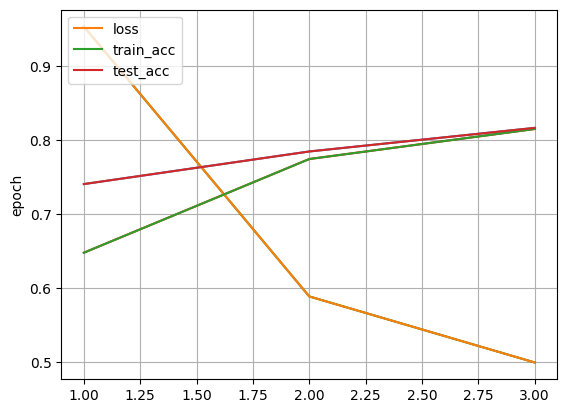

epoch 4, loss 0.4401, train acc 0.838, test acc 0.841, time 6.9 sec


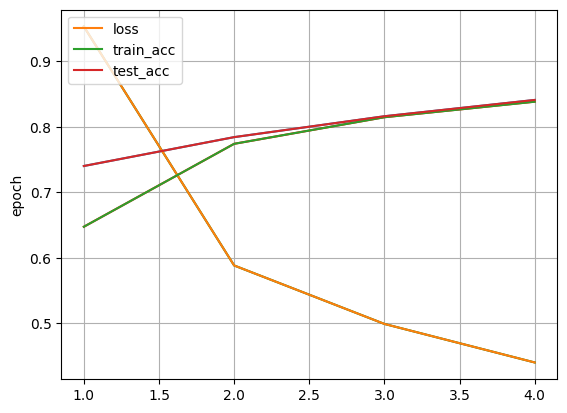

epoch 5, loss 0.4041, train acc 0.853, test acc 0.851, time 7.4 sec


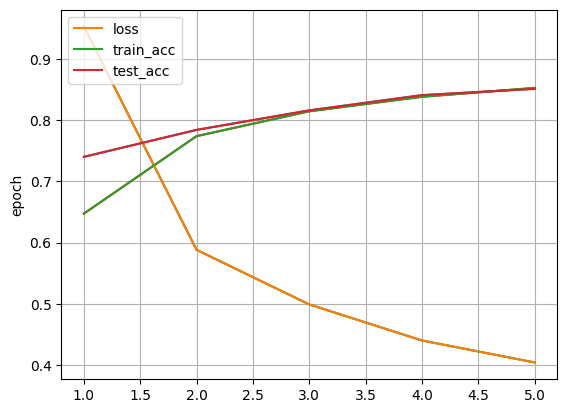

epoch 6, loss 0.3811, train acc 0.861, test acc 0.857, time 6.8 sec


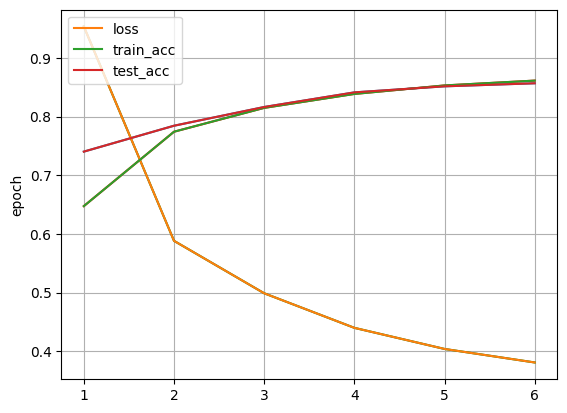

epoch 7, loss 0.3574, train acc 0.869, test acc 0.863, time 7.0 sec


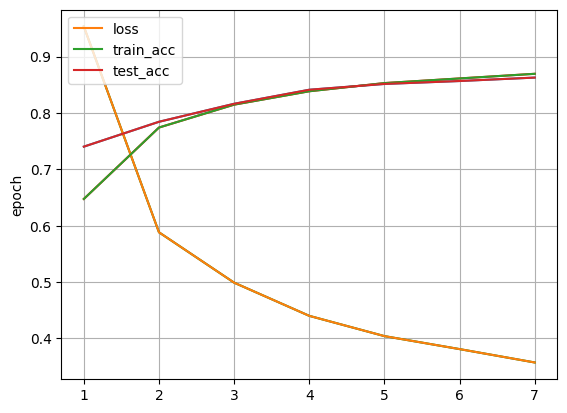

epoch 8, loss 0.3423, train acc 0.874, test acc 0.870, time 7.3 sec


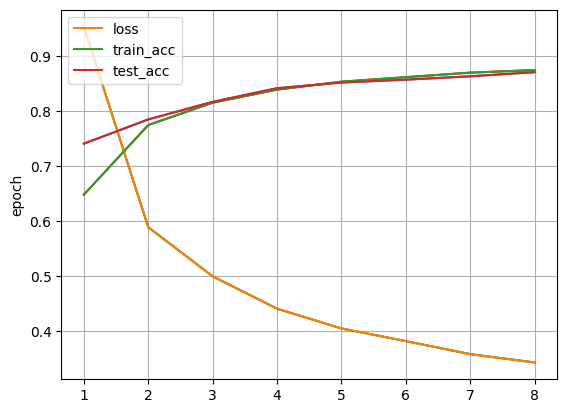

epoch 9, loss 0.3282, train acc 0.880, test acc 0.866, time 7.2 sec


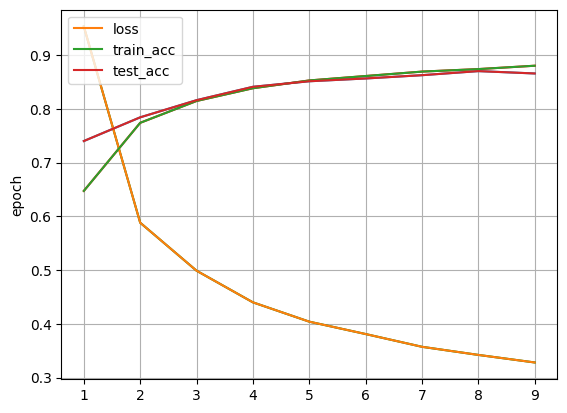

epoch 10, loss 0.3188, train acc 0.882, test acc 0.868, time 7.2 sec


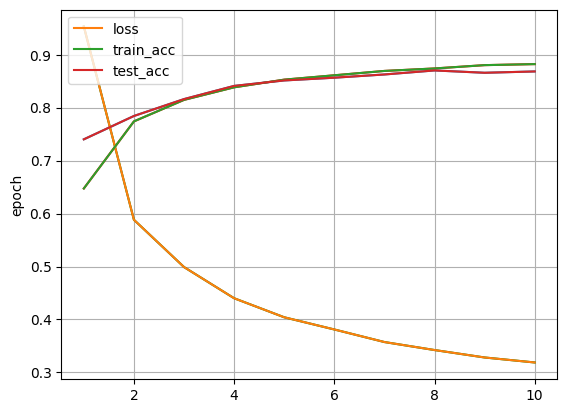

In [5]:
train(net, train_data, test_data, batch_size, optimizer, device, num_epochs)